In [25]:
# Imports
import pandas as pd
from langdetect import detect
import string
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import torch
import torch.nn as nn
import torch.optim as optim
import gensim
from gensim.models import Word2Vec
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA
from nltk.corpus import stopwords


In [2]:
# Read data
df = pd.read_csv('Dataset.csv')
print(df.head())

               song        artist  \
0         Let It Go     James Bay   
1      Love Someone  Lukas Graham   
2      Lose Control   Teddy Swims   
3  Beautiful Things  Benson Boone   
4     Make You Mine        PUBLIC   

                                              lyrics  sentiment  
0  From walking home and talking loads\nTo seeing...          0  
1  There are days\nI wake up and I pinch myself\n...          0  
2  Something's got a hold of me lately\nNo, I don...          0  
3  For a while there it was rough\nBut lately, I'...          0  
4  Girl, I will call you darling and everything w...          0  


In [3]:
# Main class for preprocessing
class Preprocessor:

    # Calculate the number of entries that got changed after processing
    def calculate_differences(self, p_list1, p_list2):

        # Number of changes after processing
        count = 0

        #Check how many fields got changed
        for i in range(len(p_list1)):
            if p_list1[i] != p_list2[i]:
                count += 1
        return count
    
    # Function that tags the part of speech
    def pos_tagger(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:          
            return None
        
    # Remove elements thay are not character strings
    def remove_non_str_elements(self, p_list):

        print(f'### Remove elements that are no strings of characters: {sum([0 if isinstance(sentence,str) else 1 for sentence in p_list])} found')
        processed_list = [sentence if isinstance(sentence, str) else '' for sentence in p_list]

        return processed_list
    
    # Remove elements from a different languages than 'lg'
    def remove_different_lg_elem(self, p_list, lg = 'en'):

        # Number of elements from other languages
        detect_count = 0
        
        processed_list = [sentence if sentence != '' and detect(sentence) == 'en' else '' for sentence in p_list]

        for i in range(len(p_list)):
            if processed_list[i] != p_list[i]:
                detect_count += 1

        print(f'### Remove songs from different languages: {detect_count} found.')

        return processed_list
    
    # Remove punctuation from the elements
    def remove_punctuation(self, p_list):

        # String that contains punctuation, whitespace and extra unicode characters
        # 'RIGHT SINGLE QUATATION MARK'
        exclude = string.punctuation + '\u2019'

        processed_list = ["".join(['' if chr in exclude else chr for chr in sentence]) for sentence in p_list]
        print(f'### Remove punctuation')

        return processed_list
    
    # Convert elements to lower case
    def lower_case(self, p_list):
        processed_list = [sentence.lower() for sentence in p_list]
        print(f'### Converting to lowercase')
        return processed_list

    # Function that returns a lemmatized list
    def lemmatize_list(self, p_list):
        
        print("### Lemmatize content")
        # Returned lemmatized list
        processed_list = []
        # Instantiate the lemmatizer class
        lemmatizer = WordNetLemmatizer()

        for sentence in p_list:
            # Use pos_tag to get complete part of speech: 'DT', 'VBZ', 'VBG', ..
            pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
            # Process the tags in simpler versions for lemmatization: 'n', 'v', 'a', None, ..
            wordnet_tagged = list(map(lambda x: (x[0], self.pos_tagger(x[1])), pos_tagged))
            lemmatized_sentence = []
            for word, tag in wordnet_tagged:
                if tag is None:
                    # if there is no available tag, append the token as is
                    lemmatized_sentence.append(word)
                else:        
                    # else use the tag to lemmatize the token
                    lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
            lemmatized_sentence = " ".join(lemmatized_sentence)
            processed_list.append(lemmatized_sentence)

        return processed_list

    # Remove non-ascii characters
    def remove_non_ascii(self, p_list):
        print('### Removing non ascii characters')
        # List of availalble ascii characters
        printable = set(string.printable)
        # Filter non ascii characters
        processed_list = [''.join(filter(lambda x: x in printable, sentence)) for sentence in p_list]

        return processed_list

    # Functon that removes numbers from the strings
    def remove_numbers(self, p_list):
        occurences = sum([len(re.findall(r'[0-9]', sentence)) for sentence in p_list])
        processed_list = [re.sub(r'[0-9]', '', sentence) for sentence in p_list] 
        print(f'### Removing numbers: {occurences} found')
        return processed_list
        
    # Replace words with correct versions of them: we ll, do nt ..
    def replace_broken_words(self, p_list):
        print('### Replacing broken words')
        # Words that will be replaced
        replace_dict = {'ll' : 'will', 'nt' : 'not', 'm' : 'am', 've' : 'have', 'ca': 'can', 's' : 'is',
                        'wan' : 'wanna', 'na' : '', 'gon' : 'gonna', 're' : 'are', 'wo' : 'will', 'd' : 'would', 'u' : 'you'}
        # Final replaced lyrics
        processed_list = []
        for sentence in p_list:
            # Processed sentence
            processed_sentence = []
            for word in sentence.split():
                word = replace_dict.get(word, word)
                processed_sentence.append(word)
            processed_sentence = ' '.join(processed_sentence)
            processed_list.append(processed_sentence)
        return processed_list

    # Replacing extra characters to increase collision
    def replace_duplicate_letters(self, p_list):
        # Replacing extra characters
        print('### Replacing extra characters')
        # Replaces "aaaaaahhhhhhhaaaaaa" with "aahhaa"
        processed_list = [re.sub(r'([a-z])\1{3,}', r'\1\1', sentence) for sentence in p_list]
        # Replaces "ahaahaahaaha with "aha"
        #processed_list = [re.sub(r'(.+?)\1+', r'\1', sentence) for sentence in p_list]
        
        return processed_list

    # Replacing numbers with words
    def replace_numbers(self, p_list):
        occurences = sum([len(re.findall(r'[0-9]+', sentence)) for sentence in p_list])
        processed_list = [re.sub(r'x?[0-9]+(nd)?x?', 'NUMBER', sentence) for sentence in p_list]
        print(f'### Replacing numbers: {occurences} found')
        return processed_list

    # Main function for preprocessing
    def main(self, p_list, remove_non_strings=True, remove_non_english=True, remove_punctuation=True, lower_case=True, lemmatize=True,
             remove_numbers=True, broken_words=True, replace_extra=True, replace_numbers=True, remove_non_ascii=True):
        print('## Preprocessing..')

        # Remove non string elements
        if remove_non_strings:
            preprocessed_list = self.remove_non_str_elements(p_list)

        # Remove elements that are in other languages than english
        if remove_non_english:
            preprocessed_list = self.remove_different_lg_elem(preprocessed_list)

        # Remove punctuation from elements
        if remove_punctuation:
            preprocessed_list = self.remove_punctuation(preprocessed_list)
                    
        # Convert characters to lowercase
        if lower_case:
            preprocessed_list = self.lower_case(preprocessed_list)

        # Lemmatize elements
        if lemmatize:
            preprocessed_list = self.lemmatize_list(preprocessed_list)

        # Remove numbers
        if remove_numbers:
            preprocessed_list = self.remove_numbers(preprocessed_list)

        # Replace broken words
        if broken_words:
            preprocessed_list = self.replace_broken_words(preprocessed_list)

        # Replace words with extra letters with simpler versions
        if replace_extra:
            preprocessed_list = self.replace_duplicate_letters(preprocessed_list)

        # Replace numbers with the work "NUMBER"
        if replace_numbers:
            preprocessed_list = self.replace_numbers(preprocessed_list)

        # Remove non ascii characters
        if remove_non_ascii:
            preprocessed_list = self.remove_non_ascii(preprocessed_list)

        print()

        return preprocessed_list


In [4]:
# Cache-ing expensive data

preprocessor = Preprocessor() 

# Unprocessed lyrics
raw_lyrics = df['lyrics'].copy()

# Lyrics that are english only, not lematized
english_lyrics = preprocessor.remove_non_str_elements(df['lyrics'])
english_lyrics = preprocessor.remove_different_lg_elem(english_lyrics)

# Lyrics that are lemmatized
lemmatized_lyrics = preprocessor.lemmatize_list(english_lyrics)

### Remove elements that are no strings of characters: 1 found
### Remove songs from different languages: 441 found.
### Lemmatize content


In [5]:
# Concatenate song, artist, lyrics for a more complete evaluation.

lemmatized_df = df.copy()
lemmatized_df['lemmatized_lyrics'] = lemmatized_lyrics
lemmatized_df['complete_lyrics'] = 'song ' + lemmatized_df['song'] + ' artist ' + lemmatized_df['artist'] + ' lyrics ' + lemmatized_df['lemmatized_lyrics']
print('Complete lyrics: ')
print(lemmatized_df['complete_lyrics'].head())

Complete lyrics: 
0    song Let It Go artist James Bay lyrics From wa...
1    song Love Someone artist Lukas Graham lyrics T...
2    song Lose Control artist Teddy Swims lyrics So...
3    song Beautiful Things artist Benson Boone lyri...
4    song Make You Mine artist PUBLIC lyrics Girl ,...
Name: complete_lyrics, dtype: object


In [6]:
# Lyrics used for preprocessing
DATAFRAME = lemmatized_df
USED_LYRICS = lemmatized_df['complete_lyrics']

# Main function 
def preprocess(p_list):

    # Initialize class used for preprocessing
    preprocessor = Preprocessor()

    # Preprocessing data
    processed_list = preprocessor.main(p_list, replace_numbers=False, remove_punctuation=True, remove_numbers=True, remove_non_english=False, lemmatize=False)

    # Sample processed data
    print(processed_list[:10])

    return processed_list

processed_lyrics =  preprocess(USED_LYRICS)

## Preprocessing..
### Remove elements that are no strings of characters: 0 found
### Remove punctuation
### Converting to lowercase
### Removing numbers: 10701 found
### Replacing broken words
### Replacing extra characters
### Removing non ascii characters

['song let it go artist james bay lyrics from walk home and talk load to see show in even clothes with you from nervous touch and get drunk to stay up and wake up with you now we are sleep near the edge holding something we do not need oh this delusion in our head is gonna  bring us to our knee so come on let it go just let it be why do not you be you and i will be me everything that is broke leave it to the breeze why do not you be you and i will be me and i will be me from throw clothes across the floor to teeth and claw and slam door at you if this be all we are live for why be we do it do it do it anymore i use to recognize myself it is funny how reflection change when we are become something else i think it is time to walk aw

In [7]:
# Processed dataset example
preprocessed_dataset = DATAFRAME.copy()
preprocessed_dataset['processed_lyrics'] = processed_lyrics
# Remove rows where lyrics were removed based on being preprocessed (dif. language, float..)
preprocessed_dataset.dropna(subset=['processed_lyrics'], inplace=True)

# Export dataset
vizualized_dataset = preprocessed_dataset.copy()
vizualized_dataset.drop(columns=['lyrics', 'lemmatized_lyrics', 'complete_lyrics'], inplace=True)
vizualized_dataset.to_csv('Preprocessed_Dataset.csv')


In [8]:
# Split data in train, val, test
DATA = preprocessed_dataset['processed_lyrics']
LABELS = preprocessed_dataset['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split(DATA, LABELS, test_size=0.1, random_state=42, stratify=LABELS)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [27]:
# Embbed data

'''
    Choose which vectorizer is used for data translation
    VECTORIZER : string = 'tfidf', 'word2vec'
'''
VECTORIZER = 'word2vec'

# Embedding vectors used for tfidf
Emb_train, Emb_val, Emb_test = [], [], []
# Word2Vec vectorizer
vectorizer = None

def tfidf():
    vectorizer = TfidfVectorizer()
    Emb_train = vectorizer.fit_transform(X_train)
    print(f'Feature names: {vectorizer.get_feature_names_out()}')
    Emb_val = vectorizer.transform(X_val)
    Emb_test = vectorizer.transform(X_test)

    return Emb_train, Emb_val, Emb_test

def word2vec(p_train):
    # Function that tokenizez sentences and removes stop words
    def preprocess_text(p_text):
        stop_words = set(stopwords.words('english'))
        # Tokenize data
        tokens = word_tokenize(p_text)
        # Remove stopwords
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        return tokens
    # Preprocess sentences from corpus
    preprocessed_sentences = [preprocess_text(sentence) for sentence in p_train]

    # Instantiate word2vec vectorizer with 100 features
    vectorizer = Word2Vec(sentences=preprocessed_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

    # Test 'word2vec' model
    try:
        similar_word_heart = vectorizer.wv.most_similar('heart', topn=5)
        print('Most similar word to heart: ', similar_word_heart)
    except KeyError as e:
         print(f"KeyError: {e}")
         
    return vectorizer

if VECTORIZER == 'tfidf':
    Emb_train, Emb_val, Emb_test = tfidf()

if VECTORIZER == 'word2vec':
    vectorizer = word2vec(X_train)



Most similar word to heart:  [('forgets', 0.7151781320571899), ('delicate', 0.7136197090148926), ('untamed', 0.6951959133148193), ('untrimmed', 0.6881721019744873), ('breaker', 0.6880008578300476)]


Word vectors:  [[-0.33495596 -0.17593203  0.13339162 ... -0.23773985  0.39122146
  -0.11911508]
 [-0.5171608  -0.11107516  0.11158746 ... -0.21787347  0.22679639
  -0.10040564]
 [-0.38825208 -0.15201995 -0.30154443 ... -0.18477479  0.37114027
  -0.05419253]
 ...
 [-0.16723014  0.05934609 -0.03267531 ... -0.07457854  0.05466788
   0.03970138]
 [-0.1608378   0.0209735  -0.01728998 ... -0.0931814   0.10099199
   0.03976859]
 [-0.16350569  0.01744817  0.00442172 ... -0.12134734  0.06033157
   0.04550219]]
Words:  ['get', 'know', 'love', 'like', 'go', 'na', 'oh', 'song', 'say', 'lyrics', 'yeah', 'artist', 'make', 'come', 'one', 'let', 'never', 'see', 'time', 'feel', 'take', 'cause', 'want', 'would', 'way', 'life', 'wan', 'baby', 'tell', 'back', 'need', 'think', 'gon', 'good', 'could', 'give', 'away', 'night', 'heart', 'right', 'ai', 'day', 'look', 'world', 'leave', 'eye', 'keep', 'thing', 'find', 'still', 'fuck', 'girl', 'fall', 'hold', 'mind', 'try', 'every', 'die', 'lose', 'us', 'man', 'e

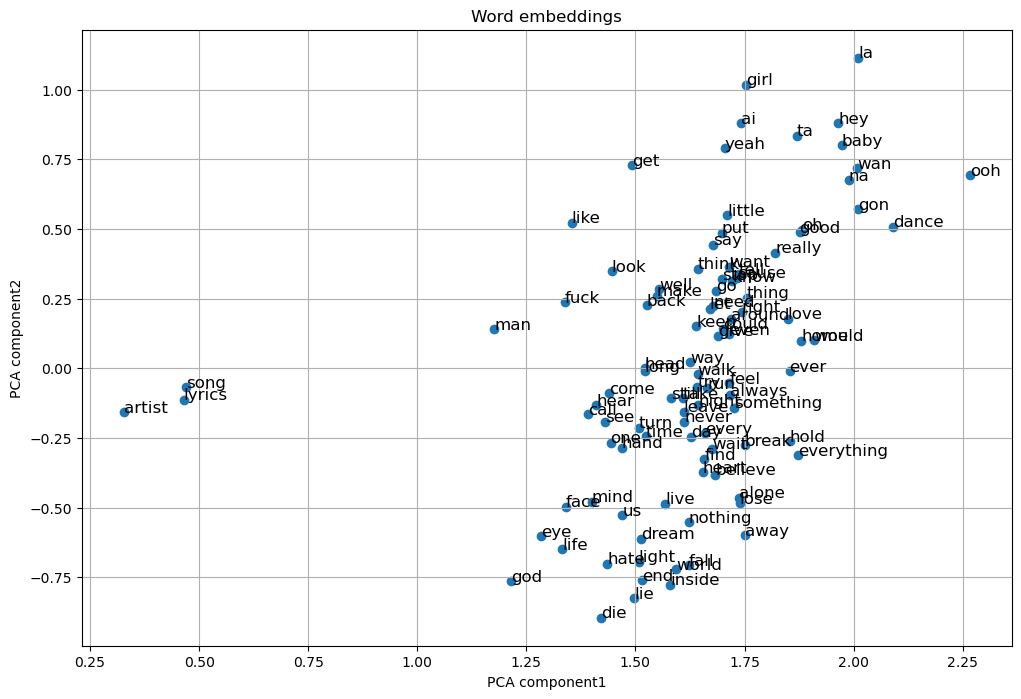

In [34]:
# Plot word similarities based on word2vec
word_vectors = vectorizer.wv[vectorizer.wv.index_to_key]
print("Word vectors: ", word_vectors)
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

plt.figure(figsize=(12,8))
# Display colored points in space
plt.scatter(result[:100,0], result[:100,1])

words = list(vectorizer.wv.index_to_key)
print("Words: ", words)
for i, word in enumerate(words[:100]):
    plt.annotate(word, xy=(result[i,0], result[i,1]), fontsize=12)

plt.title("Word embeddings")
plt.xlabel("PCA component1")
plt.ylabel("PCA component2")
plt.grid()
plt.show()


<h2> ## Logistic Regression Model ## </h2> 

In [10]:
# Use logistic regression model

'''
    Calculate the benchmark for the model without further changes
      TRAIN       precision  recall    f1-score
     macro avg     0.7732    0.7774    0.7733     
'''
model = LogisticRegression(random_state=42, multi_class='multinomial')
model.fit(Emb_train, y_train)

# Validate model on train, test, validation sets
train_pred = model.predict(Emb_train)
print('## Train results')
print(classification_report(train_pred, y_train, digits=4))

val_pred = model.predict(Emb_val)
print('## Validation results')
print(classification_report(val_pred, y_val, digits=4))

test_pred = model.predict(Emb_test)
print('## Test results')
print(classification_report(test_pred, y_test, digits=4))

'''
  #TO DO: Move this to a Visualizer class
'''
# Function that prints a heatmap to check failure distribution, pred=list(Predicted labels), truth=list(Real labels)
def plot_heat_map(p_pred, p_truth, p_labels=[0,1,2,3,4]):
    
    cm = confusion_matrix(p_truth, p_pred, labels=p_labels)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    # Sentiment: 0=Sad, 1=Love, 2=Anger, 3=Happy, 4=Fear 
    ax.xaxis.set_ticklabels(['Sad', 'Love', 'Anger', 'Happiness', 'Fear']); ax.yaxis.set_ticklabels(['Sad', 'Love', 'Anger', 'Happiness', 'Fear'])

d:\Anaconda\envs\SongAnalyzer\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Train results
              precision    recall  f1-score   support

           0     0.7645    0.7123    0.7375      2954
           1     0.7640    0.7427    0.7532      2254
           2     0.8223    0.7740    0.7975      2673
           3     0.6014    0.7517    0.6682      1744
           4     0.9089    0.9021    0.9055      1870

    accuracy                         0.7695     11495
   macro avg     0.7722    0.7766    0.7724     11495
weighted avg     0.7766    0.7695    0.7713     11495

## Validation results
              precision    recall  f1-score   support

           0     0.5686    0.4943    0.5289       176
           1     0.5984    0.6134    0.6058       119
           2     0.6286    0.5867    0.6069       150
           3     0.3802    0.5412    0.4466        85
           4     0.8447    0.7982    0.8208       109

    accuracy                         0.5962       639
   macro avg     0.6041    0.6068    0.6018       639
weighted avg     0.6103    0.5962    0

d:\Anaconda\envs\SongAnalyzer\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Heat map for model evaluation, we want to see what are the most made mistakes

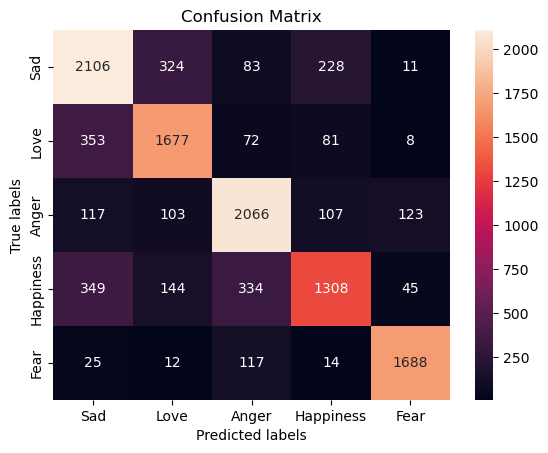

In [138]:
# Evaluate for train
plot_heat_map(train_pred, y_train)

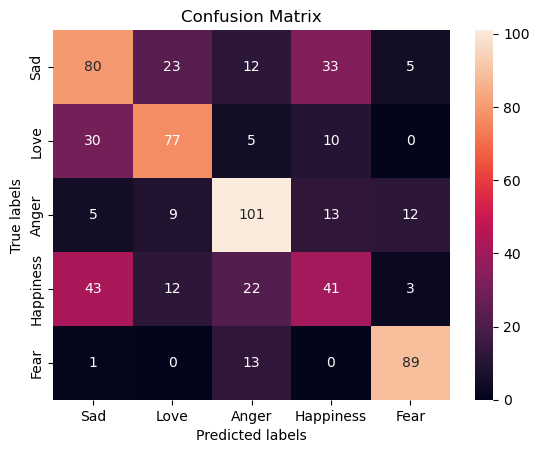

In [139]:
# Evaluate for test
plot_heat_map(test_pred, y_test)

## ## K nearest neighbours ## ##

In [140]:
# Initialize KNN classifier
model = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
model.fit(Emb_train, y_train)

# Predict and report for train
train_pred = model.predict(Emb_train)
print(classification_report(train_pred, y_train))

# Predict and report for val
val_pred = model.predict(Emb_val)
print(classification_report(val_pred, y_val))

# Predict and report for test
test_pred = model.predict(Emb_test)
print(classification_report(test_pred, y_test))


              precision    recall  f1-score   support

           0       0.79      0.52      0.63      4213
           1       0.70      0.62      0.66      2478
           2       0.57      0.77      0.66      1850
           3       0.54      0.77      0.64      1529
           4       0.71      0.92      0.80      1425

    accuracy                           0.66     11495
   macro avg       0.66      0.72      0.68     11495
weighted avg       0.69      0.66      0.66     11495

              precision    recall  f1-score   support

           0       0.56      0.35      0.43       245
           1       0.48      0.36      0.41       165
           2       0.33      0.49      0.39        94
           3       0.37      0.58      0.45        78
           4       0.50      0.89      0.64        57

    accuracy                           0.45       639
   macro avg       0.45      0.53      0.47       639
weighted avg       0.48      0.45      0.44       639

              precisio

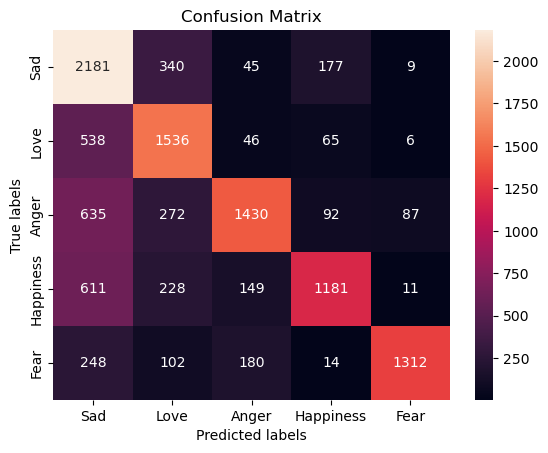

In [141]:
# Evaluate for train
plot_heat_map(train_pred, y_train)

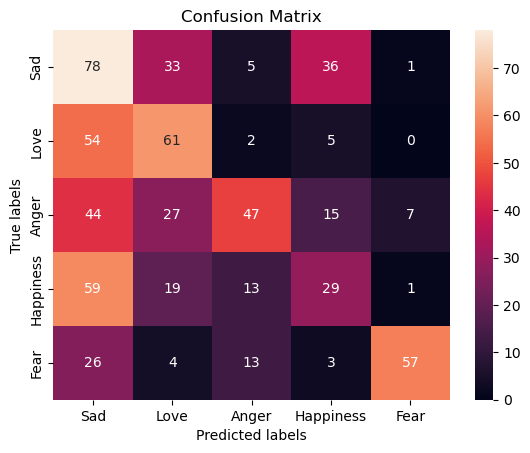

In [142]:
# Evaluate for test
plot_heat_map(test_pred, y_test)

## ## Service Vector Machine (SVM) ## ##


In [144]:
model = svm.LinearSVC()
model.fit(Emb_train, y_train)

# Predict and report for train
train_pred = model.predict(Emb_train)
print(classification_report(train_pred, y_train))

# Predict and report for val
val_pred = model.predict(Emb_val)
print(classification_report(val_pred, y_val))

# Predict and report for test
test_pred = model.predict(Emb_test)
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2741
           1       0.89      0.85      0.87      2301
           2       0.92      0.92      0.92      2537
           3       0.82      0.88      0.85      2048
           4       0.98      0.97      0.97      1868

    accuracy                           0.89     11495
   macro avg       0.89      0.89      0.89     11495
weighted avg       0.89      0.89      0.89     11495

              precision    recall  f1-score   support

           0       0.57      0.53      0.55       163
           1       0.62      0.64      0.63       118
           2       0.64      0.62      0.63       146
           3       0.52      0.58      0.55       109
           4       0.84      0.84      0.84       103

    accuracy                           0.63       639
   macro avg       0.64      0.64      0.64       639
weighted avg       0.63      0.63      0.63       639

              precisio

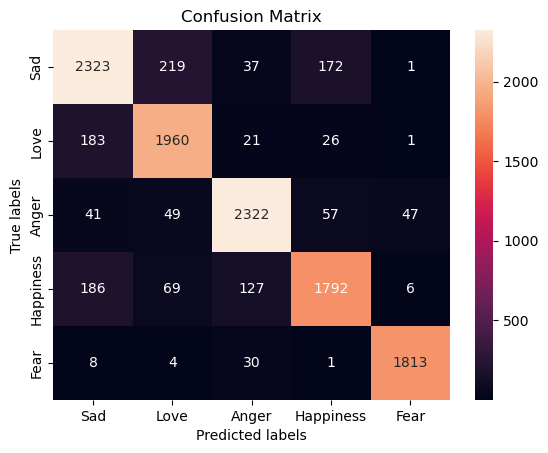

In [145]:
# Evaluate for train
plot_heat_map(train_pred, y_train)

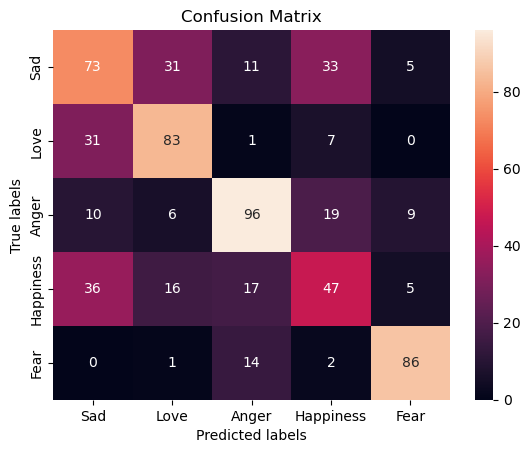

In [146]:
# Evaluate for test
plot_heat_map(test_pred, y_test)

## ## Recurrent Neural Network ## ##

In [156]:
print(Emb_train.shape)
#X = torch.tensor(Emb_train, dtype=torch.float32)

(11495, 38167)
